In [1]:
from torchvision import transforms
import sys, os
sys.path.append('.')
from sgm.data.data_nerf_synthetic import NerfSynthDataset
from sgm.data.data_multirefimage_camera_pose_correct import Co3dDataset

from sgm.modules.utils_cameraray import *
from PIL import Image
from pytorch3d.renderer import ray_bundle_to_ray_points


In [44]:
data = NerfSynthDataset('chair', single_instance=True, skip=1, mask_images=False, pose_encoding=True, posedim=320, img_size=256)
data.same_im = False
# data = Co3dDataset('car', single_instance=True, single_id=0, skip=1, mask_images=False, pose_encoding=True, posedim=320, img_size=256)
# data.same_im = False


Low quality translation sequences, not used: []
Data size: 100


In [45]:
batch = data.__getitem__(0, specific_id=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], validation=True)
batch["filepaths"], batch["pose"][0].focal_length, batch["pose"][1].principal_point

(['/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_0.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_10.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_20.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_30.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_40.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_50.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_60.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/train/r_70.png',
  '/sensei-fs/tenants/Sensei-AdobeResearchTeam/nupkumar1/generative-models/nerf_synthetic/chair/t

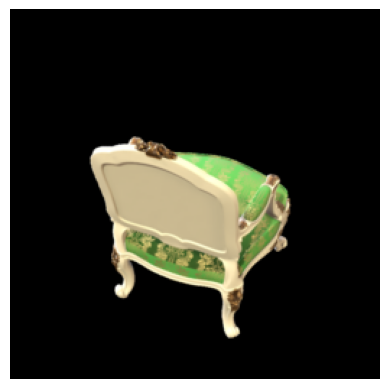

In [46]:
from PIL import Image
import matplotlib.pyplot as plt
im = np.asarray(Image.fromarray( ((batch['jpg']*0.5+0.5).permute(1,2,0).cpu().numpy()*255.).astype(np.uint8)).resize((256,256)) )
plt.axis("off")
plt.imshow(im)
plt.savefig("temp.png", bbox_inches='tight')

In [47]:
from pytorch3d.renderer.camera_utils import join_cameras_as_batch

res = 2
device = 'cuda'
pose = [join_cameras_as_batch(batch["pose"])]
input_patch_rays, xys = get_patch_rays(pose, num_patches_x=res, num_patches_y=res, device=device, return_xys=True)  # (b, n, h*w, 6)

N_samples = 8
N_rays = res*res
lengths = torch.linspace(0.01, 1.0, steps=N_samples, device=device)[None, None, :].expand(10, N_rays, -1)
target_patch_raybundle = RayBundle(origins=input_patch_rays[0, :, :, :3], directions=input_patch_rays[0, :, :, 3:],
                                   lengths=lengths.to(device), xys=xys.to(device))
ray_points = ray_bundle_to_ray_points(target_patch_raybundle)


In [48]:
centers = pose[0].get_camera_center()
centers.min(dim=0), centers.max(dim=0), centers.shape,  len(batch["pose"][0]), input_patch_rays.shape, ray_points.shape, 

(torch.return_types.min(
 values=tensor([-0.4351, -0.5764,  0.1535]),
 indices=tensor([4, 8, 5])),
 torch.return_types.max(
 values=tensor([0.9375, 0.9345, 0.7856]),
 indices=tensor([5, 1, 4])),
 torch.Size([10, 3]),
 1,
 torch.Size([1, 10, 4, 6]),
 torch.Size([10, 4, 8, 3]))

In [49]:
import plotly
from pytorch3d.renderer.cameras import PerspectiveCameras
from pytorch3d.renderer import  TexturesUV, TexturesAtlas
from pytorch3d.structures import Meshes, packed_to_list
import pytorch3d
from pytorch3d.vis.plotly_vis import plot_scene, AxisArgs

import plotly.graph_objects as go

def grid_mesh_from_view(cameras, image, s=0.5, f=2, rotate=True, device=device):
    view_to_world = cameras.get_world_to_view_transform().inverse()
    horizontal_patch_edges = torch.linspace(-s, s, 257)[:-1]
    vertical_patch_edges = torch.linspace(-s, s, 257)[:-1]
    
    h_pos, v_pos = torch.meshgrid(horizontal_patch_edges, vertical_patch_edges)  # (num_patches_y, num_patches_x), (num_patches_y, num_patches_x)
    points = torch.stack([h_pos.reshape(-1), v_pos.reshape(-1), torch.ones_like(h_pos.reshape(-1)) * f]).to(device)
    print(points.shape, points.device)
    
    points = view_to_world.transform_points(points.T)
    print(points.shape)

    return points.cpu().numpy(), image


scenes = {
            "subplot1_title": {
                "ray_bundle_trace_title": target_patch_raybundle,
                "cameras_trace_title": pose[0],
            },
        }
camera_scale=0.15
fig = plot_scene(
        scenes,
        camera_scale=camera_scale,
        ncols=2,
        axis_args=AxisArgs(showline=True, zeroline=True, backgroundcolor="rgb(200,230,200)")
    )

for i in range(len(pose[0])):
    if i==0:
        image = batch['jpg']
    else:
        image = batch['jpg_ref'][i-1]
    image = image.permute(2,1,0)
    camera = pose[0][i].to(device)
    points, image = grid_mesh_from_view(camera.to(device), image, s=camera_scale, f=2*camera_scale, rotate=True, device='cuda')
    fig.add_trace(
        go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                marker={"color":image.reshape(-1,3), "size":1,},
            ),
            row=1,
            col=1,
    )

fig.update_scenes(aspectmode="data")

HTML_TEMPLATE = """<html><head><meta charset="utf-8"/></head>
<body>{plotly_html}</body></html>"""


html_plot = plotly.io.to_html(fig, full_html=False, include_plotlyjs="cdn")
with open('temp.html', "w") as f:
        s = HTML_TEMPLATE.format(
            plotly_html=html_plot,
        )
        f.write(s)



torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
torch.Size([3, 65536]) cuda:0
torch.Size([65536, 3])
